# Annotate the differential abundance results

In [49]:
# importing all required packages & notebook extensions at the start of the notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
from pathlib import Path
import requests
import xml.etree.ElementTree as ET

%matplotlib inline

In [17]:
# set pd column width to display full text
pd.set_option('display.max_colwidth', 150)

In [3]:
# get project root by finding .git folder
root = !git rev-parse --show-toplevel
root = Path(root[0])

# assigning variables throughout the notebook
raw_data_dir = root / "data" / "raw"
data_dir = root / "data" / "processed"
vis_dir  = root / "results"

In [38]:
import sys
sys.path.append(root.as_posix())

from secret import BIOCYC_PW, BIOCYC_USER
import utils

## KEGG

## EC

In [12]:
ec_vis_dir = vis_dir / "ec_metagenome_downstream_analysis"

Download EXPASY enzyme database as a reference for EC numbers.

In [4]:
! wget -O $data_dir/ec_metagenome_downstream_analysis/enzyme.dat https://ftp.expasy.org/databases/enzyme/enzyme.dat

--2024-12-21 16:19:29--  https://ftp.expasy.org/databases/enzyme/enzyme.dat
Resolving ftp.expasy.org (ftp.expasy.org)... 192.33.215.162
Connecting to ftp.expasy.org (ftp.expasy.org)|192.33.215.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9428206 (9.0M) [text/plain]
Saving to: ‘/home/matchy233/study/alien/data/processed/ec_metagenome_downstream_analysis/enzyme.dat’

/home/matchy233/stu 100%[===================>]   8.99M  31.6MB/s    in 0.3s    

2024-12-21 16:19:29 (31.6 MB/s) - ‘/home/matchy233/study/alien/data/processed/ec_metagenome_downstream_analysis/enzyme.dat’ saved [9428206/9428206]



Read previous results (from `07_b_downstream_analysis/02_ec_analysis.ipynb`) 

In [30]:
lfc_ec = pd.read_csv(ec_vis_dir / "significant_enzymes_by_cohort.csv")
lfc_ec.head()

,metagene,log2foldchange_After abduction,q-value_After abduction
0,EC:1.1.1.103,-1.687152,0.040528
1,EC:1.1.1.14,-1.845816,0.000927
2,EC:1.1.1.159,-2.563178,0.000004
3,EC:1.1.1.261,-2.384744,0.000262
4,EC:1.1.1.267,-1.575203,0.000110


In [31]:
# define top level enzyme classes
enzyme_mapping_level1 = {
    "EC:1": "Oxidoreductases",
    "EC:2": "Transferases",
    "EC:3": "Hydrolases",
    "EC:4": "Lyases",
    "EC:5": "Isomerases",
    "EC:6": "Ligases",
    "EC:7": "Translocases",
}


In [32]:
# use the mapping to get the level 1 enzyme class
lfc_ec["enzyme_class"] = lfc_ec.loc[:,"metagene"].apply(
    lambda x: enzyme_mapping_level1[x.split(".")[0]]
)


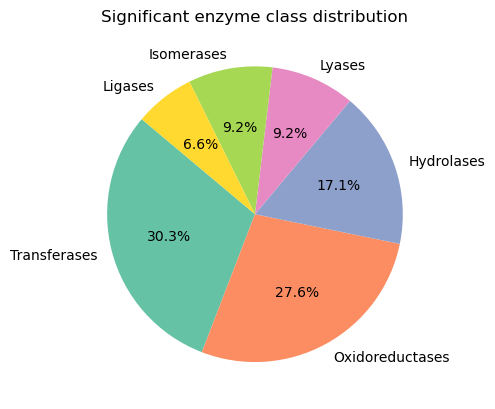

In [33]:
# plot enzyme class distribution as a pie chart
ax = lfc_ec["enzyme_class"].value_counts().plot.pie(
    autopct="%1.1f%%", startangle=140, colors=sns.color_palette("Set2")
)
ax.set_ylabel("")
ax.set_title("Significant enzyme class distribution")

plt.savefig(ec_vis_dir / "significant_enzyme_class_pie_chart.png", dpi=300)

In [34]:
# import biopython ExPASy module
from Bio.ExPASy import Enzyme
handle = open(data_dir / "ec_metagenome_downstream_analysis" / "enzyme.dat")
records = Enzyme.parse(handle)
enzyme_mapping = {
    record["ID"]: record["DE"].rstrip(".") for record in records
}

In [35]:
# sort lfc_qval_significant by lfc
lfc_ec["enzyme"] = lfc_ec["metagene"].apply(
    lambda x: enzyme_mapping.get(x.split(":")[1], "Unknown")
)
lfc_ec = lfc_ec.sort_values(by="log2foldchange_After abduction", ascending=True)

# show depleted enzymes that are < 5% compared to before abduction
lfc_ec[lfc_ec["log2foldchange_After abduction"] < -3][["metagene", "enzyme_class", "enzyme"]]


,metagene,enzyme_class,enzyme
61,EC:2.4.1.5,Transferases,dextransucrase
51,EC:2.1.1.245,Transferases,5-methyltetrahydrosarcinapterin:corrinoid/iron-sulfur proteinCo-methyltransferase
100,EC:3.5.1.26,Hydrolases,N(4)-(beta-N-acetylglucosaminyl)-L-asparaginase
54,EC:2.1.1.258,Transferases,5-methyltetrahydrofolate:corrinoid/iron-sulfur proteinCo-methyltransferase
56,EC:2.3.1.169,Transferases,CO-methylating acetyl-CoA synthase
40,EC:1.8.98.1,Oxidoreductases,dihydromethanophenazine:CoB--CoM heterodisulfide reductase
60,EC:2.4.1.4,Transferases,amylosucrase
58,EC:2.4.1.211,Transferases,"1,3-beta-galactosyl-N-acetylhexosamine phosphorylase"
110,EC:3.6.1.15,Hydrolases,nucleoside-triphosphate phosphatase


In [36]:
lfc_ec.to_csv(ec_vis_dir / "significant_enzymes_by_cohort_annotated.csv", index=False)

### MetaCyc pathways

In [44]:
pathabun_vis_dir = vis_dir / "pathway_abundance_downstream_analysis"

In [46]:
lfc_metacyc = pd.read_csv(pathabun_vis_dir / "significant_pathways_by_cohort.csv")
lfc_metacyc.head()

,metagene,log2foldchange_After abduction,q-value_After abduction
0,ARG+POLYAMINE-SYN,-1.127526,0.003732
1,ASPASN-PWY,-1.230605,0.000123
2,CENTFERM-PWY,-1.625897,0.000388
3,COBALSYN-PWY,-1.637630,0.000092
4,DAPLYSINESYN-PWY,-1.094884,0.000129


In [70]:
def get_pathway_name_from_biocyc(session: requests.Session, pathway_id: str):
    URL = f"https://websvc.biocyc.org/getxml?id=META:{pathway_id}"
    response = session.get(URL)
    if response.status_code != 200:
        return "Unknown"
    root = ET.fromstring(response.text)
    pathway_name = root.find(".//Pathway/common-name").text
    return pathway_name

In [47]:
# connect to BioCyc
s = requests.Session()  # create session
# Post login credentials to session:
r = s.post(
    "https://websvc.biocyc.org/credentials/login/",
    data={"email": BIOCYC_USER, "password": BIOCYC_PW},
)

# Check if login was successful
r.status_code


200

In [71]:
lfc_metacyc["pathway_name"] = lfc_metacyc["metagene"].apply(
    lambda x: get_pathway_name_from_biocyc(s, x)
)
lfc_metacyc.head()

,metagene,log2foldchange_After abduction,q-value_After abduction,pathway_name
0,ARG+POLYAMINE-SYN,-1.127526,0.003732,Unknown
1,ASPASN-PWY,-1.230605,0.000123,superpathway of L-aspartate and L-asparagine biosynthesis
2,CENTFERM-PWY,-1.625897,0.000388,pyruvate fermentation to butanoate
3,COBALSYN-PWY,-1.637630,0.000092,superpathway of adenosylcobalamin salvage from cobinamide I
4,DAPLYSINESYN-PWY,-1.094884,0.000129,L-lysine biosynthesis I


In [75]:
# remove <i> tags from pathway names
lfc_metacyc["pathway_name"] = (
    lfc_metacyc["pathway_name"].str.replace("<i>", "").str.replace("</i>", "")
)
lfc_metacyc = lfc_metacyc.sort_values(
    by="log2foldchange_After abduction", ascending=True
)
lfc_metacyc.head(20)

,metagene,log2foldchange_After abduction,q-value_After abduction,pathway_name
10,METH-ACETATE-PWY,-3.053729,1.004840e-08,methanogenesis from acetate
44,PWY-7332,-2.889324,2.581338e-03,superpathway of UDP-<I>N-acetylglucosamine-derived O-antigen building blocks biosynthesis
11,NAD-BIOSYNTHESIS-II,-2.519755,2.837803e-05,NAD salvage pathway III (to nicotinamide riboside)
6,FUCCAT-PWY,-2.422689,1.664643e-09,L-fucose degradation I
40,PWY-7198,-2.396626,1.639304e-03,pyrimidine deoxyribonucleotides de novo biosynthesis IV
41,PWY-7210,-2.372636,2.498562e-03,pyrimidine deoxyribonucleotides biosynthesis from CTP
25,PWY-5676,-2.369860,3.555472e-02,acetyl-CoA fermentation to butanoate
13,P162-PWY,-2.325231,1.902229e-03,L-glutamate degradation V (via hydroxyglutarate)
28,PWY-5705,-2.304107,4.970931e-07,allantoin degradation to glyoxylate III
26,PWY-5677,-2.296525,4.348278e-04,succinate fermentation to butanoate


In [76]:
lfc_metacyc.to_csv(pathabun_vis_dir / "significant_pathways_by_cohort_annotated.csv", index=False)